In [1]:
import numpy as np
import torch
import os

In [2]:
if not os.path.exists('facial_keypoints.npz'):
  !wget -O facial_keypoints.npz "https://www.dropbox.com/scl/fi/27qggijmythfjg04s24xq/facial_keypoints.npz?rlkey=h91gwodhrfuz8hrc7ux9qnq7s&dl=1"

In [3]:
data = np.load('facial_keypoints.npz')
images = data['images']
keypoints = data['keypoints']

In [4]:

print("Image array shape:", images.shape)  # (num_images, num_channels, height, width)
print("Keypoints array shape:", keypoints.shape)

print("Image dtype:", images.dtype)
print("Keypoints dtype:", keypoints.dtype)

print("Image min:", np.min(images)) # 0(Black)-255(White)
print("Image max:", np.max(images))

print("Keypoints min:", np.nanmin(keypoints)) #values represent coordinates
print("Keypoints max:", np.nanmax(keypoints))


Image array shape: (7049, 1, 96, 96)
Keypoints array shape: (7049, 30)
Image dtype: int64
Keypoints dtype: float32
Image min: 0
Image max: 255
Keypoints min: 0.686592
Keypoints max: 95.935646


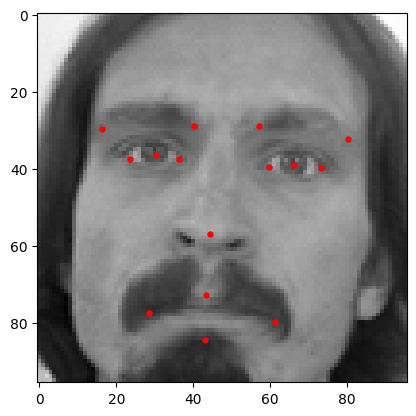

In [5]:
import matplotlib.pyplot as plt

plt.imshow(images[0].squeeze(), cmap='gray')
plt.scatter(keypoints[0][0::2], keypoints[0][1::2], s=50, marker='.', c='r')
plt.show()

In [6]:
#preprocessing and TT Split
import numpy as np
import sklearn
from sklearn.preprocessing import MinMaxScaler

images = images.astype(np.float32) / 255.0

scalar = MinMaxScaler()
mask = ~np.isnan(keypoints)
keypoints_scaled = keypoints.copy()
keypoints_scaled[mask] = scalar.fit_transform(keypoints[mask].reshape(-1, 1)).flatten()

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    images, keypoints_scaled, test_size=0.1, random_state=42
)


In [7]:
#3 preparing DataSet and DataLoaders
from torch.utils.data import TensorDataset, DataLoader

X_train = torch.from_numpy(X_train)
y_train = torch.from_numpy(y_train)
X_test = torch.from_numpy(X_test)
y_test = torch.from_numpy(y_test)

train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [8]:
!pip install torchmetrics

In [9]:
import torch
import torch.nn as nn
import torchmetrics

device = torch.device("cuda")

In [10]:
# Creating Model
cnn = nn.Sequential(
    nn.Conv2d(1, 8, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.Conv2d(8, 8, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Conv2d(8, 16, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Conv2d(16, 32, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.Conv2d(32, 64, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(64 * 12 * 12, 1024),
    nn.ReLU(),
    nn.Linear(1024, 1024),
    nn.ReLU(),
    nn.Linear(1024, 30)
).to(device)

In [11]:
def masked_mae_loss(y_pred,y_true):
    mask = 1-torch.isnan(y_true).float()
    diff = torch.abs(y_true-y_pred)
    return torch.nansum(diff*mask)/torch.nansum(mask)

In [12]:
#Training
def train_model(model, train_loader, test_loader, num_epochs=10):
  model = model.to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
  model.train()

  for epoch in range(num_epochs):
    epoch_loss = 0.0
    for x_batch, y_batch in train_loader:
      x_batch = x_batch.to(device)
      y_batch = y_batch.to(device)
      optimizer.zero_grad()
      y_pred = model(x_batch)
      loss = masked_mae_loss(y_pred, y_batch)
      loss.backward()
      optimizer.step()
      epoch_loss += loss.item()

    epoch_loss /= len(train_loader)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss}")

In [13]:
train_model(cnn, train_loader, test_loader)

Epoch 1/20, Loss: 0.0467794615887667
Epoch 2/20, Loss: 0.03251604320266139
Epoch 3/20, Loss: 0.030497342535299274
Epoch 4/20, Loss: 0.029738580779963403
Epoch 5/20, Loss: 0.02862236006700214
Epoch 6/20, Loss: 0.025527876460147862
Epoch 7/20, Loss: 0.021652147435962256
Epoch 8/20, Loss: 0.02038292565743378
Epoch 9/20, Loss: 0.018342015890395223
Epoch 10/20, Loss: 0.01833433286759572
Epoch 11/20, Loss: 0.016645611516532287
Epoch 12/20, Loss: 0.01589330831477091
Epoch 13/20, Loss: 0.015331988026336509
Epoch 14/20, Loss: 0.014732806807636615
Epoch 15/20, Loss: 0.014152603167759714
Epoch 16/20, Loss: 0.013526517570243408
Epoch 17/20, Loss: 0.0135146500215159
Epoch 18/20, Loss: 0.012364409494227799
Epoch 19/20, Loss: 0.01274790136078045
Epoch 20/20, Loss: 0.01211872443687826


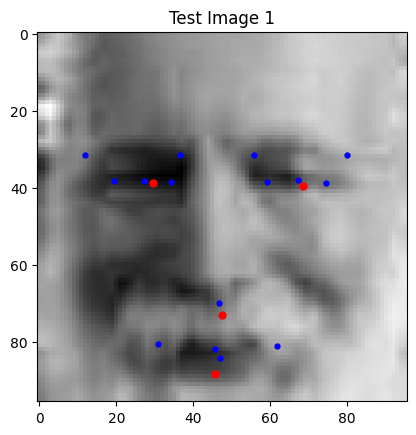

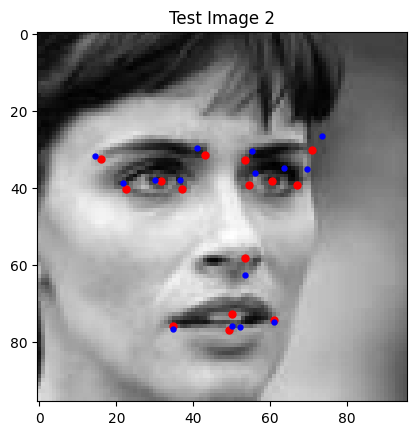

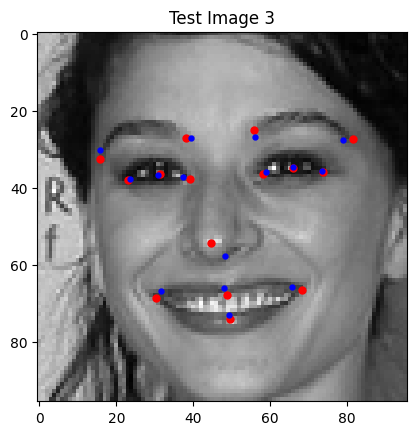

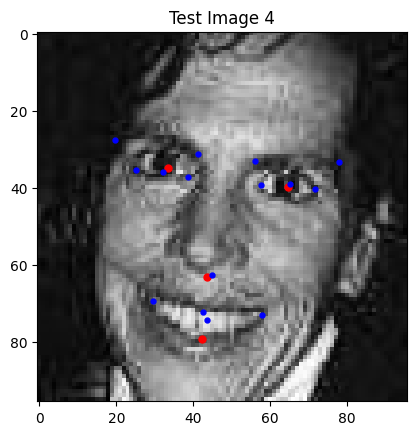

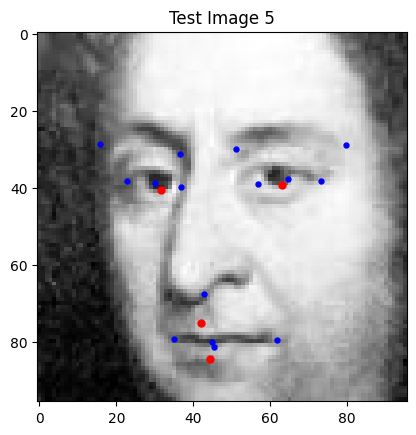

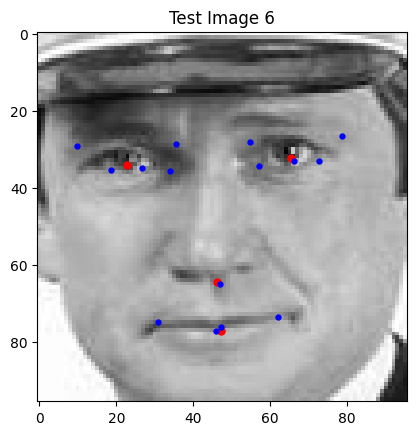

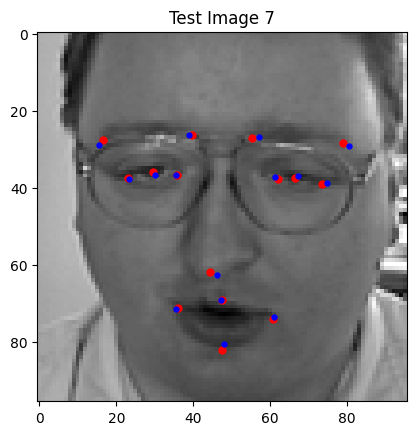

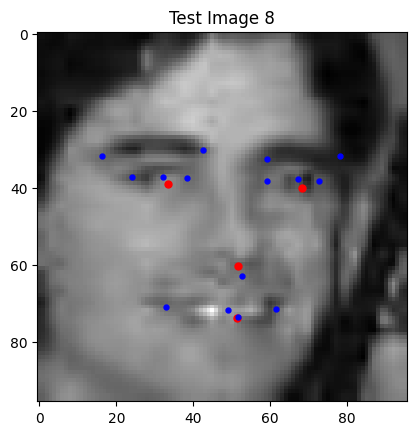

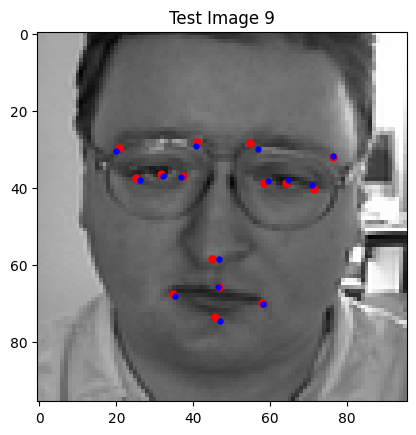

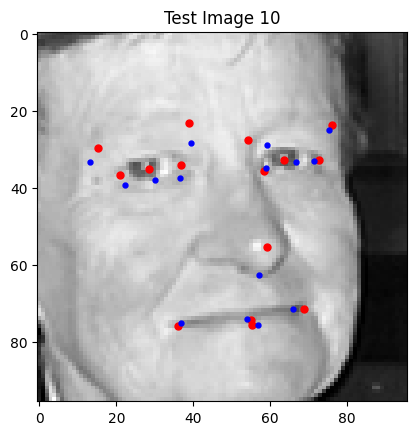

In [14]:
#Visualization
for i in range(10):
  image, true_keypoints = test_loader.dataset[i]
  image_tensor = torch.unsqueeze(image, 0).to(device)
  image = image.cpu().numpy().transpose(1, 2, 0)

  true_keypoints = true_keypoints.cpu().numpy()
  true_keypoints = scalar.inverse_transform(true_keypoints.reshape(-1, 1)).flatten()
  pred_keypoints = cnn(image_tensor).cpu().detach().numpy()
  pred_keypoints = scalar.inverse_transform(pred_keypoints.reshape(-1, 1)).flatten()

  plt.imshow(image, cmap='gray')
  plt.scatter(true_keypoints[0::2], true_keypoints[1::2], s=100, marker='.', c='r')
  plt.scatter(pred_keypoints[0::2], pred_keypoints[1::2], s=50, marker='.', c='b')
  plt.title(f'Test Image {i+1}')
  plt.show()


In [15]:
# Calc Error
import numpy as np

total_error = 0
num_samples = 0

for x_batch, y_batch in test_loader:
    x_batch = x_batch.to(device)
    y_batch = y_batch.to(device)

    y_pred = cnn(x_batch)
    mask = 1 - torch.isnan(y_batch).float()
    diff = torch.abs(y_batch - y_pred)
    error = torch.nansum(diff * mask)
    total_error += error.item()
    num_samples += torch.sum(mask).item()

average_error = total_error / num_samples
print(f"Average Error: {average_error}")

Average Error: 0.013192045755164567
